<font color='123B64'> <font size = 10>  
    
# Using PyTorch to predict the outcome of a pitch in baseball: Ball or Strike

<font color='black'> <font size = 4>  

**Sánchez Cortés Miguel Ángel**  
Facultad de Ciencias, UNAM.
    
miguel.sanchezcortes@ciencias.unam.mx

<font color='black'> <font size = 4> <div style="text-align: justify">

In this project we will need several packages to make the most of our data and our results. Mainly, [Matplotlib](https://matplotlib.org), [Numpy](https://numpy.org) and [Pandas](https://pandas.pydata.org) are very common packages for data manipulation, analysis and plotting. [PyTorch](https://pytorch.org) is an open source machine learning framework that accelerates the path from research prototyping to production deployment and [Scikit Learn](https://scikit-learn.org/stable/) is a free software machine learning library for the Python programming language.

In [1]:
import pandas as pd #We import pandas as pd
import numpy as np #We import numpy as np
import matplotlib #We import matplotlib
import matplotlib.pyplot as plt #We import pyplot as plt
import networkx as nx #We import networkx as nx
import torch #We import pytorch
import torch.optim as optim #We import pyplot as plt
import torch.nn as nn #We import nn as nn
import torch.nn.functional as F #We import functional as F
from sklearn.metrics import accuracy_score #We import metrics as accuracy_score

#We will plot with LaTeX format

matplotlib.rcParams['text.usetex'] = True
plt.rc('font', family='serif')
plt.rc('text', usetex=True)

<font color='8CC6FF'> <font size = 5>  
    
**1.- The problem to solve**

<font color='black'> <font size = 4> <div style="text-align: justify">

In the game of baseball, the objective of the pitcher is to throw the ball in a certain area and avoid the bat of the opponent so he can't hit it. To do this, the pitcher has to throw what is denominated a "strike".
<br> 
    
An example of a strike can be seen in the following animation:

<img src = "./Images/kershaw.gif">

<font color='black'> <font size = 4>  

The strike happens when the batter swings or misses at the throw and the ball goes through a zone known as the "strike-zone". The strike-zone is defined as the volume that is formed above the "home plate" and between the knees of the batter and the midpoint of its torso.

<img src='./Images/strikezone.jpg' width="400">

<font color='black'> <font size = 4>  

Every throw that is not a strike is called a "ball" and it's the job of the umpire to determine if a throw is a strike or a ball. The main goal of this project is to implement a neural network that does the same job as an umpire (roughly) i.e. identify between a strike or a ball.

<font color='black'> <font size = 4>  

The MLB (Major League Baseball) is one of the top leagues regarding collection of data and data analysis to improve the game and the performance of their players, that's why they publish big datasets for the general public or research teams to analyze. In this case we're going to work with a curated version of a [dataset](https://gist.github.com/nkreeger/43edc6e6daecc2cb02a2dd3293a08f29) obtained by **PITCHf/x**.

<br>    
**PITCHf/x**, is a system that tracks the speeds and trajectories of pitched baseballs. This system is installed in every MLB stadium. The data from the system is often used by broadcasters to show a visual representation of the pitch and whether or not a pitch entered the strike-zone. PITCHf/x is also used to determine the type of pitch thrown, such as a fastball, curve, or slider.  

<font color='black'> <font size = 4>  
The dataset we're going to use is a subset of the data obtained by **PITCHf/x** for several years and includes the principal factors that determine if a throw was a ball or a strike (depending on what the umpire said). The dataframe looks like this: 

In [2]:
df = pd.read_csv('sz-train-data.csv', sep =',')
df

,px,pz,sz_top,sz_bot,left_handed_batter,is_strike
0,0.539113,2.587213,3.621919,1.684979,1,1
1,0.185254,1.563559,3.723780,1.832007,0,1
2,0.803388,2.260778,3.622781,1.685562,0,1
3,0.930117,2.414831,3.652374,1.777228,1,1
4,0.627324,2.404645,3.578980,1.707845,0,1
...,...,...,...,...,...,...
4995,-1.393689,0.283122,3.487617,1.638531,0,0
4996,0.872779,0.708333,3.381560,1.521567,0,0
4997,1.384588,2.370364,3.319000,1.513000,0,0
4998,0.526299,0.876783,3.517436,1.635414,0,0


<font color='black'> <font size = 4> 
    
As we can see, we have **6 main characteristics**, where **5 are input characteristics** and have the following meaning:
    
- **"px"** and **"pz"** are the coordinates in x and z where the ball crosses the plane formed above the home plate. This coordinates are measured in ft and the origin is given by the midpoint of the home plate.
    
- **"sz_top"** is the coordinate of the top limit of the strikezone and **"sz_bot"** is the coordinate of the bottom limit of the strikezone. This coordinates are measured in ft and the origin is given by the home plate.
    
- **"left_handed_batter"** gives us the answer to the question: "Is the batter left handed?" It's value is 1 if it is True and 0 if it is False.

We also have **1 output** that depends on the characteristics mentioned above and it is:
    
- **"is_strike"** gives us the answer to the question: "Was the throw a strike?" It's value is 1 if it is True and 0 if it is False.

<font color='black'> <font size = 4> 
We have 5000 samples in total, in fact, 2500 are samples of a strike and 2500 are samples of a ball.

In [3]:
print("The length of the dataframe is: ", len(df))

The length of the dataframe is:  5000


In [4]:
#This is the first half of the data
df[:2500]

,px,pz,sz_top,sz_bot,left_handed_batter,is_strike
0,0.539113,2.587213,3.621919,1.684979,1,1
1,0.185254,1.563559,3.723780,1.832007,0,1
2,0.803388,2.260778,3.622781,1.685562,0,1
3,0.930117,2.414831,3.652374,1.777228,1,1
4,0.627324,2.404645,3.578980,1.707845,0,1
...,...,...,...,...,...,...
2495,0.662516,2.002532,3.397681,1.551287,0,1
2496,0.719112,2.071470,3.237017,1.551363,0,1
2497,0.643908,3.032396,3.570195,1.657748,0,1
2498,-0.235052,1.594047,3.713668,1.757791,1,1


In [5]:
#This is the second half of the data
df[2500:]

,px,pz,sz_top,sz_bot,left_handed_batter,is_strike
2500,-2.445494,2.447305,3.368796,1.685271,0,0
2501,-1.799024,2.148282,3.378342,1.653433,0,0
2502,-0.940878,1.595694,3.399827,1.705965,0,0
2503,-1.511470,2.654238,3.296390,1.602493,0,0
2504,0.787675,2.826297,3.434307,1.692996,1,0
...,...,...,...,...,...,...
4995,-1.393689,0.283122,3.487617,1.638531,0,0
4996,0.872779,0.708333,3.381560,1.521567,0,0
4997,1.384588,2.370364,3.319000,1.513000,0,0
4998,0.526299,0.876783,3.517436,1.635414,0,0


<font color='8CC6FF'> <font size = 5>  
    
**2.- Separation and data analysis**

<font color='black'> <font size = 4> 

Let's see an individual sample of the dataset

In [7]:
df[:1]

,px,pz,sz_top,sz_bot,left_handed_batter,is_strike
0,0.539113,2.587213,3.621919,1.684979,1,1


<font color='black'> <font size = 4> 

Notice that using the data given above we can reconstruct the exact coordinate where the ball crossed the strike-zone. In this case, if we graph the strike-zone (noticing that the home plate's width is 17 ft) and plot the point where the ball passed, we can see graphically if the throw was a ball or a strike.

In [8]:
#First we define some arrays with the coordinates of the pitch and the homeplate
pitch= np.array([df.iloc[0][0],df.iloc[0][1]])
sz= np.array([df.iloc[0][2],df.iloc[0][3]])
home=1.41667

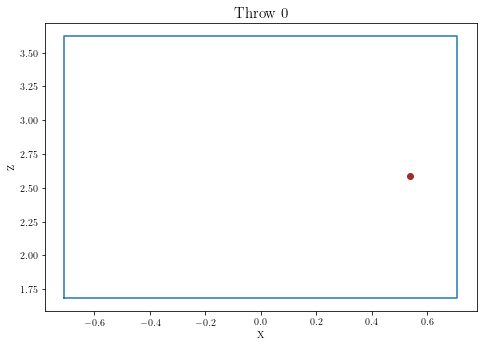

In [9]:
#We Plot
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(pitch[0], pitch[1], color='brown')
plt.plot([-home/2,home/2,home/2,-home/2,-home/2], [sz[1],sz[1],sz[0],sz[0],sz[1]], '-')
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_title('Throw 0', {'fontsize': 15})
plt.savefig("./Images/Throw1.png",dpi=300,bbox_inches="tight")

<font color='black'> <font size = 4> 

As we can see, this is a strike.
    
<br>
    
Now we can do the same thing for a throw that is labeled as a strike:

In [10]:
df[-1:]

,px,pz,sz_top,sz_bot,left_handed_batter,is_strike
4999,0.097945,3.661204,3.299139,1.477017,0,0


In [11]:
#First we define some arrays with the coordinates of the pitch and the homeplate
pitch2= np.array([df.iloc[-1][0],df.iloc[-1][1]])
sz2= np.array([df.iloc[-1][2],df.iloc[-1][3]])
home=1.41667

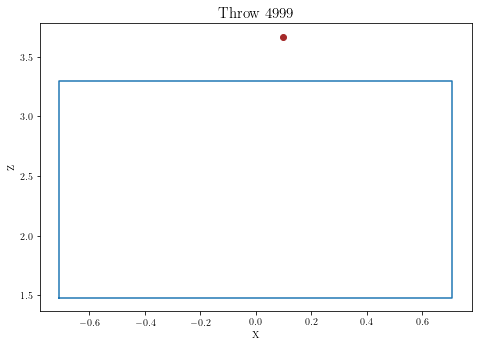

In [12]:
#We plot
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(pitch2[0], pitch2[1], color='brown')
plt.plot([-home/2,home/2,home/2,-home/2,-home/2], [sz2[1],sz2[1],sz2[0],sz2[0],sz2[1]], '-')
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_title('Throw 4999',{'fontsize': 15})
plt.savefig("./Images/Throw4999.png",dpi=300,bbox_inches="tight")

<font color='black'> <font size = 4> 

As we can confirm, this is a ball.

<font color='black'> <font size = 4> 

It is useful to plot the histogram of the whole dataset. This gives us a notion of the limits of our data values.

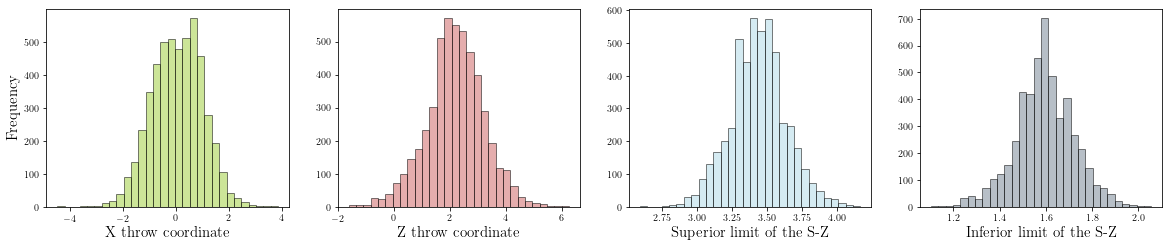

In [13]:
#We plot some histograms
fig = plt.figure(figsize=(20,8)) 

ax1 = plt.subplot(2,4,1)
ax2 = plt.subplot(2,4,2)
ax3 = plt.subplot(2,4,3)
ax4 = plt.subplot(2,4,4)

ax1.hist(df.px, bins=30, color='yellowgreen',edgecolor='black', alpha=0.5)
ax1.set_xlabel('X throw coordinate', size=15)
ax1.set_ylabel('Frequency', size=15)

ax2.hist(df.pz, bins=30, color='indianred',edgecolor='black', alpha=0.5)
ax2.set_xlabel('Z throw coordinate', size=15);

ax3.hist(df.sz_top, bins=30, color='lightblue',edgecolor='black', alpha=0.5)
ax3.set_xlabel('Superior limit of the S-Z', size=15);

ax4.hist(df.sz_bot, bins=30, color='slategray',edgecolor='black', alpha=0.5)
ax4.set_xlabel('Inferior limit of the S-Z', size=15);

plt.savefig("./Images/hist1.png",dpi=300,bbox_inches="tight")

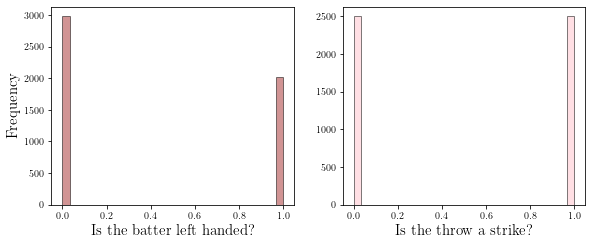

In [14]:
#We plot the other histograms
fig = plt.figure(figsize=(20,8)) 

ax5 = plt.subplot(2,4,1)
ax6 = plt.subplot(2,4,2)

ax5.hist(df.left_handed_batter, bins=30, color='brown',edgecolor='black', alpha=0.5)
ax5.set_xlabel('Is the batter left handed?', size=15)
ax5.set_ylabel('Frequency', size=15)

ax6.hist(df.is_strike, bins=30, color='pink',edgecolor='black', alpha=0.5)
ax6.set_xlabel('Is the throw a strike?', size=15);

plt.savefig("./Images/hist2.png",dpi=300,bbox_inches="tight")

<font color='black'> <font size = 4> 

Now, we can sample the data to avoid bias when training and divide it in a training set (90% of the total dataset) and a test set (10% of the total dataset).

In [15]:
#We sample the data with a random seed to reproduce the data
np.random.seed(1)
df = df.sample(frac=1)
df.head()

,px,pz,sz_top,sz_bot,left_handed_batter,is_strike
2764,-1.311703,0.706626,3.275232,1.617182,0,0
4767,-1.549807,-0.190490,3.322346,1.523619,0,0
3814,-0.435908,1.151633,3.411000,1.565000,0,0
3499,0.081753,1.091413,3.384008,1.618902,1,0
2735,-0.544799,1.340813,3.754808,1.800967,0,0


In [16]:
#We divide the data
test_ratio = 0.1

train_ratio = int((1.0-test_ratio)*len(df.values[:,:]))

df_train = df.iloc[0:train_ratio,:]
df_test  = df.iloc[train_ratio:,:]

In [17]:
print("The shape of the train set is: ", df_train.shape)
print("The shape of the test set es: ", df_test.shape)

The shape of the train set is:  (4500, 6)
The shape of the test set es:  (500, 6)


<font color='black'> <font size = 4> 

**It's not necessary to normalize the data, this is a special case because we obtained an already curated set from PITCHf/x**.    

In [18]:
#We can divide the dataset in input and output and look at it's shape:
x_train = df_train.values[:,:-1]
y_train = df_train.values[:,-1:]
x_test = df_test.values[:,:-1]
y_test = df_test.values[:,-1:]

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(4500, 5)
(4500, 1)
(500, 5)
(500, 1)


<font color='black'> <font size = 4> 

We can define the validation set, which can be obtained dividing again the training set (in a 90%-10% fashion).

In [19]:
#We obtain a validation set
val_ratio = 0.1
train_ratio = int((1.0-val_ratio)*x_train.shape[0])
X_val = x_train[train_ratio:,:]
Y_val = y_train[train_ratio:,:]

X_train = x_train[:train_ratio,:]
Y_train = y_train[:train_ratio,:]

<font color='black'> <font size = 4> 

As we're going to use the PyTorch framework it is useful to convert the datasets to tensors so we can work with them in the future:

In [20]:
train_x= torch.Tensor(np.array(X_train)).type(torch.FloatTensor)
train_y = torch.Tensor(np.squeeze(Y_train)).type(torch.LongTensor)
val_x = torch.Tensor(np.array(X_val)).type(torch.FloatTensor)
val_y = torch.Tensor(np.squeeze(Y_val)).type(torch.LongTensor)
test_x = torch.Tensor(np.array(x_test)).type(torch.FloatTensor)
test_y = torch.tensor(np.squeeze(y_test)).type(torch.LongTensor)

In [21]:
print("The shape of the x values of the training set is: ", train_x.shape)
print("The shape of the y values of the training set is: ", train_y.shape)
print("The shape of the x values of the validation set is: ", val_x.shape)
print("The shape of the y values of the validation set is: ", val_y.shape)
print("The shape of the x values of the test set is: ", test_x.shape)
print("The shape of the y values of the test set is: ", test_y.shape)

The shape of the x values of the training set is:  torch.Size([4050, 5])
The shape of the y values of the training set is:  torch.Size([4050])
The shape of the x values of the validation set is:  torch.Size([450, 5])
The shape of the y values of the validation set is:  torch.Size([450])
The shape of the x values of the test set is:  torch.Size([500, 5])
The shape of the y values of the test set is:  torch.Size([500])


<font color='8CC6FF'> <font size = 5>  
    
**3.- Definition, training and evaluation of the neural network.**

<font color='black'> <font size = 4> 

Finally, we can start by defining the Neural Network we're going to work with. Graphically, we can represent this network in the following manner:

In [24]:
#This class graphs a neural network with the help of the NetworkX package
class Network(object):
    
    def  __init__ (self,sizes):
        self.num_layers = len(sizes)
        print("It has", self.num_layers, "layers,")
        self.sizes = sizes
        print("with the following number of nodes per layer", self.sizes)
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x)
                        for x, y in zip(sizes[:-1], sizes[1:])]
        
    def feedforward(self, x_of_sample):
        """Return the output of the network F(x_of_sample) """        
        for b, w in zip(self.biases, self.weights):
            x_of_sample = sigmoid(np.dot(w, x_of_sample)+b)
        return x_of_sample
    
    def graph(self,sizes):
        a=[]
        ps={}
        Q = nx.Graph()
        for i in range(len(sizes)):
            Qi=nx.Graph()    
            n=sizes[i]
            nodos=np.arange(n)
            Qi.add_nodes_from(nodos)
            l_i=Qi.nodes
            Q = nx.union(Q, Qi, rename = (None, 'Q%i-'%i))
            if len(l_i)==1:
                ps['Q%i-0'%i]=[i/(len(sizes)), 1/2]
            else:
                for j in range(len(l_i)+1):
                    ps['Q%i-%i'%(i,j)]=[i/(len(sizes)),(1/(len(l_i)*len(l_i)))+(j/(len(l_i)))]
            a.insert(i,Qi)
        for i in range(len(a)-1):
            for j in range(len(a[i])):
                for k in range(len(a[i+1])):
                    Q.add_edge('Q%i-%i' %(i,j),'Q%i-%i' %(i+1,k))
        nx.draw(Q, pos = ps)

It has 6 layers,
with the following number of nodes per layer [5, 24, 16, 8, 2, 1]


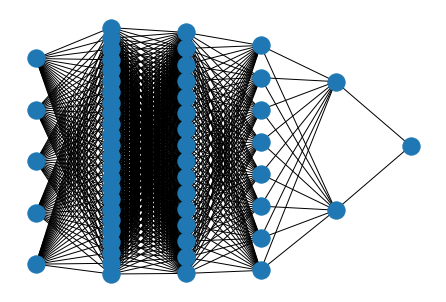

In [25]:
n_x = x_train.shape[1] 
n_h1 = 24
n_h2 = 16
n_h3 = 8
n_h4 = 2
n_y = y_train.shape[1]
    
layers = [n_x, n_h1, n_h2, n_h3, n_h4, n_y]
net = Network(layers)
net.graph(layers)

<font color='black'> <font size = 4> 

As we can see, this is a 6 layer network: 1 input layer, 4 hidden layers and 1 output layer, in this case we have [5 ,24 ,16, 8, 2, 1] nodes per layer. The architecture of the network is the following:

In [26]:
#Our network has 6 layers and is defined by the following class:
class MyClassifier(nn.Module):
    def __init__(self):
        super(MyClassifier,self).__init__()
        #We apply a linear function to the input data
        self.fc1 = nn.Linear(5,24)
        #We apply dropout to the edges of the first layer
        self.drop1 = nn.Dropout(p=0.01)
        #We apply a linear function to the input of the second layer
        self.fc2 = nn.Linear(24,16)
        #We apply dropout to the edges of the second layer
        self.drop2 = nn.Dropout(p=0.01)
        #We apply a linear function to the input of the third layer
        self.fc3 = nn.Linear(16, 8)
        #We apply dropout to the edges of the third layer
        self.drop3 = nn.Dropout(p=0.01)
        #We apply a linear function to the input of the fourth layer
        self.fc4 = nn.Linear(8, 2)

    def forward(self,x):
        #Output of the first layer
        x = self.fc1(x)
        #The activation function is the ReLu
        x = F.relu(x)
        #We apply the dropout
        x = self.drop1(x)
        #Output of the second layer
        x = self.fc2(x)
        #The activation function is the ReLu
        x = F.relu(x)
        #We apply the dropout
        x = self.drop2(x)
        #Output of the third layer
        x = self.fc3(x)
        #The activation function is the ReLu
        x = F.relu(x)
        #We apply the dropout
        x = self.drop3(x)
        #Output of the fourth layer
        x = self.fc4(x)
        return x
        
    #This function takes the last output and predicts the class (0,1)
    def predict(self,x):
        #We apply the Softmax function to the output 
        pred = F.softmax(self.forward(x),dim=1)
        ans = []
        #We choose the class with more weight
        for t in pred:
            if t[0]>t[1]:
                ans.append(0)
            else:
                ans.append(1)
        return torch.tensor(ans)

<font color='black'> <font size = 4> 
Once we define the network we can initialize the model, the cost function and an optimizer. In this case:

In [27]:
#We initialize the model 
model = MyClassifier()
#We define the cost function
criterion = nn.CrossEntropyLoss()
#We define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

<font color='black'> <font size = 4> 

Now, we are ready to train the network:

In [28]:
#We define the number of epochs
epochs = 10000

#We define the lists to save the costs
losses_train = []
losses_val = []

for i in range(epochs):
    #We predict the output given the training and validation sets
    y_pred = model.forward(train_x)
    y_val = model.forward(val_x)
    #We obtain the loss
    loss_train = criterion(y_pred,train_y)
    loss_val = criterion(y_val,val_y)
    #We append the loss
    losses_train.append(loss_train.item())
    losses_val.append(loss_val.item())
    #We clear the gradients
    optimizer.zero_grad()
    #We obtain the gradients
    loss_train.backward()
    loss_val.backward()
    #We adjust the weights
    optimizer.step()

In [29]:
print("The model accuracy for the training set is: ", accuracy_score(model.predict(train_x),train_y))
print("The model accuracy for the validation set is: ",accuracy_score(model.predict(val_x),val_y))
print("The model accuracy for the test set is: ",accuracy_score(model.predict(test_x),test_y))

The model accuracy for the training set is:  0.9288888888888889
The model accuracy for the validation set is:  0.9888888888888889
The model accuracy for the test set is:  0.9


<font color='black'> <font size = 4> 
    
We can plot the cost of the training in function of the epochs:

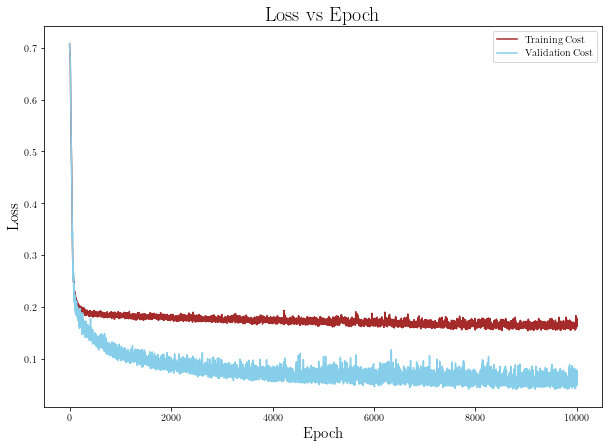

In [30]:
fig= plt.figure(figsize=(10, 7))

plt.plot(range(epochs), losses_train, color='brown')
plt.plot(range(epochs), losses_val, color='skyblue')
plt.xlabel('Epoch', size=15)
plt.ylabel('Loss', size=15)
plt.title('Loss vs Epoch',{'fontsize': 20})
plt.legend(['Training Cost', 'Validation Cost']);

plt.savefig("./Images/loss.png",dpi=300,bbox_inches="tight")

<font color='8CC6FF'> <font size = 5>  
    
**4.- Inference.**

<font color='black'> <font size = 4> 

We can make inference using our test set and our Neural Network to observe how well it predicts the outcomes of the pitches. We define a predict function:

In [31]:
def predict(x):
    #We convert an array in a tensor
    x = torch.from_numpy(x).type(torch.FloatTensor)
    #We predict and return the result
    ans = model.predict(x)
    return ans.numpy()

<font color='black'> <font size = 4> 

With this function we can obtain the prediction of the model and compare it with it's label. In this case we can see:

In [32]:
sample = 60

print("For the sample:",sample)

if predict(x_test)[sample] == 1:
    if y_test[sample] == 1:
        print("The model and the umpire predict a strike.")
    else:
        print("The model predicts a strike, but the umpire predicts a ball.")
else:
    if y_test[sample] == 1:
        print("The model predicts a ball, but the umpire predicts a strike.")
    else:
        print("The model and the umpire predict a ball.")

For the sample: 60
The model and the umpire predict a strike.


<font color='black'> <font size = 4> 

Graphically, we can observe if a pitch is effectively a strike or a ball:

In [33]:
#We define the coordinates
pitch= x_test[sample][:2]
sz= x_test[sample][2:4]
home=1.41667

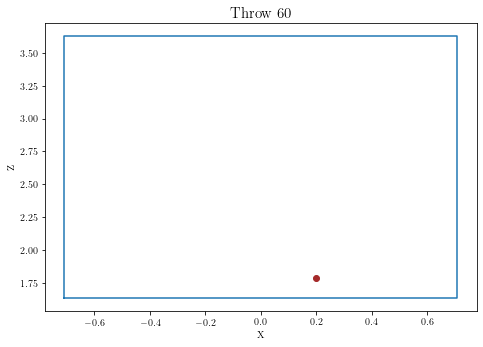

In [34]:
#We plot
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(pitch[0], pitch[1], color='brown')
plt.plot([-home/2,home/2,home/2,-home/2,-home/2], [sz[1],sz[1],sz[0],sz[0],sz[1]], '-')
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_title('Throw '+str(sample), {'fontsize': 15})
plt.savefig("./Images/ThrowTest.png",dpi=300,bbox_inches="tight")

<font color='8CC6FF'> <font size = 5>  
    
**5.- References**

<font color='black'> <font size = 4> 
    
- This network was built with the help of: **Tania Soto Contreras**.
- The original data is from: https://gist.github.com/nkreeger/43edc6e6daecc2cb02a2dd3293a08f29
- [Predicting balls and strikes using Tensorflow.js](https://medium.com/tensorflow/predicting-balls-and-strikes-using-tensorflow-js-2acf1d7a447c).